<hr>
<table style="width:100%">
  <tr>

<th><img align="center" src="https://www.cienciasdelaadministracion.uns.edu.ar/wp-content/themes/enlighten-pro/images/logo-uns-horizontal.png" width="500"/></th>
    <th><img align="center" src="https://imaglabs.org/wp-content/uploads/2018/10/LCI_logo-1.png" width="800"/></th>
  </tr>
</table>


#Convolutional Autoencoder to eliminate noise in CT images of Breast Cancer

### **Authors:**
* Katherym Bambague Ruiz
* Steven Martinez Vargas 

##Libraries

In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/drive'
  print("Colab: mounting Google drive on ", mount)
  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/MyDrive/Proyectos_extra/breats_cancer"
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root


We're running Colab
Colab: mounting Google drive on  /content/drive
Mounted at /content/drive

Colab: Changing directory to  /content/drive/MyDrive/Proyectos_extra/breats_cancer
/content/drive/MyDrive/Proyectos_extra/breats_cancer


In [2]:
#install pydicom library to open tc dcim images
#!pip install pydicom
#import load_dataset as ld
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import h5py
from sklearn.model_selection import train_test_split

##Dataset settings

###Get dataset

In [3]:
# Use to generate the Dataset with the TC images (.dcim), once created the first time it will be saved 
# in a compressed hdf5 file, which can be accessed in the following code cell
# --> uncomment to use

"""rute = '/content/drive/MyDrive/Datasets/breast_cancer'
rute_pc ='/Users/stevenmartine/Documents/Datasets/Breast_Katherym/Computed tomography/Selection'
n_tc = 100 # número de tomografias a evaluar (1-100)
Dataset_img, Data_clases, Data_names = ld.dataset(url=rute, n_clases=n_tc, downsampling=2)"""

"rute = '/content/drive/MyDrive/Datasets/breast_cancer'\nrute_pc ='/Users/stevenmartine/Documents/Datasets/Breast_Katherym/Computed tomography/Selection'\nn_tc = 100 # número de tomografias a evaluar (1-100)\nDataset_img, Data_clases, Data_names = ld.dataset(url=rute, n_clases=n_tc, downsampling=2)"

In [4]:
# Save Set of images, for later use
# --> uncomment to use

"""with h5py.File('/content/drive/MyDrive/Proyectos_extra/breats_cancer/Data_128.hdf5', 'w') as f:
    dset = f.create_dataset("default", data=Dataset_img)"""

'with h5py.File(\'/content/drive/MyDrive/Proyectos_extra/breats_cancer/Data_128.hdf5\', \'w\') as f:\n    dset = f.create_dataset("default", data=Dataset_img)'

###Open dataset

In [5]:
# Open Set images
f = h5py.File('/content/drive/MyDrive/Proyectos_extra/breats_cancer/Data_128.hdf5', 'r')
Dataset_img = f['default']

###Fit dataset

Type data nd_array: float32
Shape Dataset: (3343, 1, 128, 128)


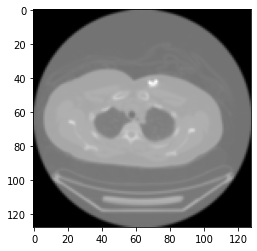

In [6]:
Data_img = np.copy((Dataset_img))
Data_img = Data_img.astype(np.float32) # Type data -> float32
Data_img = Data_img[:,np.newaxis,:,:] # Add one more dimension to the dataset, to adjust the pytorch training requirements (N,1,128,128)
plt.imshow(Data_img[1,0,:,:], cmap='gray')
print('Type data nd_array:', Data_img.dtype)
print('Shape Dataset:', Data_img.shape)

#### Training an testing Data

In [7]:
data_index = np.arange(Data_img.shape[0])
train_index, test_index = train_test_split(data_index, test_size=0.2, random_state=42)
print('Length train_index:', len(train_index))
print('Length test_index:', len(test_index))

Length train_index: 2674
Length test_index: 669


In [155]:
train_data = Data_img[train_index,:,:,:]
test_data = Data_img[test_index,:,:,:]
print('Shape train_data:', train_data.shape)
print('Shape test_data:', test_data.shape)

Shape train_data: (2674, 1, 128, 128)
Shape test_data: (669, 1, 128, 128)


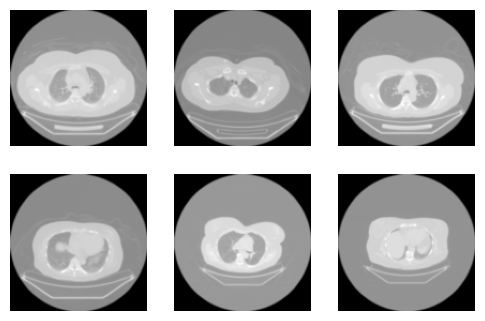

In [9]:
# Plot some images of Training Data
index_train_data = [1, 10, 100, 300, 500, 1000, 1500, 2500]
fig, ax = plt.subplots(2, 3, dpi=100) 
ax[0,0].imshow(train_data[index_train_data[0],0,:,:], cmap='gray')
ax[0,0].axis('off')
ax[0,1].imshow(train_data[index_train_data[1],0,:,:], cmap='gray')
ax[0,1].axis('off')
ax[0,2].imshow(train_data[index_train_data[2],0,:,:], cmap='gray')
ax[0,2].axis('off')
ax[1,0].imshow(train_data[index_train_data[3],0,:,:], cmap='gray')
ax[1,0].axis('off')
ax[1,1].imshow(train_data[index_train_data[4],0,:,:], cmap='gray')
ax[1,1].axis('off')
ax[1,2].imshow(train_data[index_train_data[5],0,:,:], cmap='gray')
ax[1,2].axis('off')
plt.show()
fig.savefig("Training_data.png",dpi=300)

####Get Tensor

torch.float32
torch.Size([2674, 1, 128, 128])


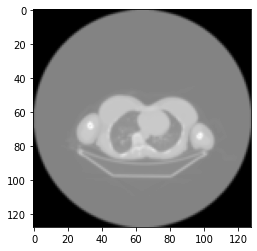

In [10]:
# Convert array to tensor pytorch
Data_tensor = torch.from_numpy(train_data)
plt.imshow(Data_tensor[0,0,:,:], cmap='gray') 
print(Data_tensor.dtype)
print(Data_tensor.shape) 

In [88]:
#Get the pytorch training dataset
train_load = torch.utils.data.DataLoader(dataset=Data_tensor, batch_size=1, shuffle=True) 
test_tensor = torch.from_numpy(test_data) 
test_load = torch.utils.data.DataLoader(dataset=test_tensor, batch_size=1, shuffle=False) 

##Convolutional Autoencoder

In [89]:
class Convolutional_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        
        # N, 1, 128, 128
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),                              # N, 64, 64, 64
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),                                             # N, 64, 32, 32
            nn.Conv2d(64, 128, 3, stride=2, padding=1),                            # N, 128, 16, 16
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),                                             # N, 128, 8, 8
            nn.Conv2d(128, 256, 3, stride=3, padding=1),                           # N, 256, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),                                             # N, 256, 2, 2
        )
        
        # N, 256, 2, 2
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3),                                       # N, 128, 4, 4 
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # N, 64, 8, 8 
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # N, 32, 16, 16  
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # N, 16, 32, 32  
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 4, 3, stride=2, padding=1, output_padding=1),   # N, 4, 64, 64  
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 1, 3, stride=2, padding=1, output_padding=1),    # N, 1, 128, 128  
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

##Model Training

In [91]:
model = Convolutional_Autoencoder()

In [92]:
#Loss function
criterion = nn.MSELoss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0' #use Colab GPU
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


Convolutional_Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU(i

In [105]:
# Point to training loop video
num_epochs = 200
outputs_train = []
total_train_loss =[]
total_test_loss =[]
for epoch in tqdm (range(100, num_epochs)):
    # monitor training loss
    train_loss = 0.0
    test_loss = 0.0
    for (img) in train_load:
        # =================== Forward =====================
        if device == 'cuda:0':
            img = img.to(device)
        recon = model(img)
        loss = criterion(recon, img)
        # =================== Backward ====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*img.size(0)
    # ================ Evaluate image test ================    
    output_test = [model(im_test.to(device)) for (im_test) in test_load] 
    test_loss = [criterion(output_test[test_index], test_tensor[test_index].to(device)) for test_index in range(len(output_test))]
    test_loss = np.array([test_loss[test_index].detach().cpu().numpy() for test_index in range(len(output_test))]).sum()
    test_loss = test_loss/len(test_load)
    # ===================== Log ===========================
    outputs_train.append((epoch+1, img, recon))
    train_loss = train_loss/len(train_load)
    total_train_loss.append((train_loss))
    total_test_loss.append((test_loss))
    print(' Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(epoch+1, train_loss, test_loss))


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([1, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:19<32:24, 19.64s/it]

 Epoch: 101 	Training Loss: 0.001171 	Test Loss: 0.001105


  2%|▏         | 2/100 [00:38<31:28, 19.27s/it]

 Epoch: 102 	Training Loss: 0.001118 	Test Loss: 0.001134


  3%|▎         | 3/100 [00:57<30:53, 19.11s/it]

 Epoch: 103 	Training Loss: 0.001105 	Test Loss: 0.001105


  4%|▍         | 4/100 [01:16<30:32, 19.09s/it]

 Epoch: 104 	Training Loss: 0.001137 	Test Loss: 0.001144


  5%|▌         | 5/100 [01:35<30:13, 19.09s/it]

 Epoch: 105 	Training Loss: 0.001153 	Test Loss: 0.001207


  6%|▌         | 6/100 [01:55<30:06, 19.22s/it]

 Epoch: 106 	Training Loss: 0.001172 	Test Loss: 0.001193


  7%|▋         | 7/100 [02:14<29:55, 19.31s/it]

 Epoch: 107 	Training Loss: 0.001095 	Test Loss: 0.001114


  8%|▊         | 8/100 [02:34<29:39, 19.34s/it]

 Epoch: 108 	Training Loss: 0.001134 	Test Loss: 0.001157


  9%|▉         | 9/100 [02:53<29:12, 19.26s/it]

 Epoch: 109 	Training Loss: 0.001149 	Test Loss: 0.001133


 10%|█         | 10/100 [03:12<28:51, 19.23s/it]

 Epoch: 110 	Training Loss: 0.001120 	Test Loss: 0.001086


 11%|█         | 11/100 [03:31<28:33, 19.25s/it]

 Epoch: 111 	Training Loss: 0.001121 	Test Loss: 0.001062


 12%|█▏        | 12/100 [03:50<28:09, 19.20s/it]

 Epoch: 112 	Training Loss: 0.001123 	Test Loss: 0.001090


 13%|█▎        | 13/100 [04:09<27:52, 19.22s/it]

 Epoch: 113 	Training Loss: 0.001120 	Test Loss: 0.001137


 14%|█▍        | 14/100 [04:28<27:26, 19.14s/it]

 Epoch: 114 	Training Loss: 0.001118 	Test Loss: 0.001082


 15%|█▌        | 15/100 [04:48<27:11, 19.20s/it]

 Epoch: 115 	Training Loss: 0.001098 	Test Loss: 0.001088


 16%|█▌        | 16/100 [05:07<26:55, 19.23s/it]

 Epoch: 116 	Training Loss: 0.001109 	Test Loss: 0.001104


 17%|█▋        | 17/100 [05:27<26:42, 19.31s/it]

 Epoch: 117 	Training Loss: 0.001120 	Test Loss: 0.001094


 18%|█▊        | 18/100 [05:46<26:31, 19.41s/it]

 Epoch: 118 	Training Loss: 0.001149 	Test Loss: 0.001112


 19%|█▉        | 19/100 [06:06<26:10, 19.39s/it]

 Epoch: 119 	Training Loss: 0.001097 	Test Loss: 0.001102


 20%|██        | 20/100 [06:25<25:45, 19.32s/it]

 Epoch: 120 	Training Loss: 0.001172 	Test Loss: 0.001103


 21%|██        | 21/100 [06:44<25:22, 19.27s/it]

 Epoch: 121 	Training Loss: 0.001120 	Test Loss: 0.001093


 22%|██▏       | 22/100 [07:03<24:57, 19.20s/it]

 Epoch: 122 	Training Loss: 0.001127 	Test Loss: 0.001124


 23%|██▎       | 23/100 [07:22<24:34, 19.15s/it]

 Epoch: 123 	Training Loss: 0.001099 	Test Loss: 0.001153


 24%|██▍       | 24/100 [07:41<24:15, 19.15s/it]

 Epoch: 124 	Training Loss: 0.001113 	Test Loss: 0.001162


 25%|██▌       | 25/100 [08:00<23:54, 19.13s/it]

 Epoch: 125 	Training Loss: 0.001160 	Test Loss: 0.001184


 26%|██▌       | 26/100 [08:19<23:33, 19.10s/it]

 Epoch: 126 	Training Loss: 0.001139 	Test Loss: 0.001104


 27%|██▋       | 27/100 [08:38<23:18, 19.16s/it]

 Epoch: 127 	Training Loss: 0.001105 	Test Loss: 0.001195


 28%|██▊       | 28/100 [08:58<22:57, 19.14s/it]

 Epoch: 128 	Training Loss: 0.001107 	Test Loss: 0.001124


 29%|██▉       | 29/100 [09:17<22:38, 19.13s/it]

 Epoch: 129 	Training Loss: 0.001143 	Test Loss: 0.001074


 30%|███       | 30/100 [09:36<22:18, 19.12s/it]

 Epoch: 130 	Training Loss: 0.001085 	Test Loss: 0.001091


 31%|███       | 31/100 [09:55<22:00, 19.14s/it]

 Epoch: 131 	Training Loss: 0.001106 	Test Loss: 0.001098


 32%|███▏      | 32/100 [10:14<21:36, 19.06s/it]

 Epoch: 132 	Training Loss: 0.001104 	Test Loss: 0.001180


 33%|███▎      | 33/100 [10:33<21:16, 19.05s/it]

 Epoch: 133 	Training Loss: 0.001115 	Test Loss: 0.001159


 34%|███▍      | 34/100 [10:52<20:53, 18.99s/it]

 Epoch: 134 	Training Loss: 0.001148 	Test Loss: 0.001097


 35%|███▌      | 35/100 [11:11<20:38, 19.06s/it]

 Epoch: 135 	Training Loss: 0.001153 	Test Loss: 0.001151


 36%|███▌      | 36/100 [11:30<20:17, 19.02s/it]

 Epoch: 136 	Training Loss: 0.001094 	Test Loss: 0.001083


 37%|███▋      | 37/100 [11:49<19:56, 19.00s/it]

 Epoch: 137 	Training Loss: 0.001148 	Test Loss: 0.001126


 38%|███▊      | 38/100 [12:08<19:34, 18.94s/it]

 Epoch: 138 	Training Loss: 0.001126 	Test Loss: 0.001173


 39%|███▉      | 39/100 [12:27<19:15, 18.94s/it]

 Epoch: 139 	Training Loss: 0.001137 	Test Loss: 0.001105


 40%|████      | 40/100 [12:45<18:54, 18.92s/it]

 Epoch: 140 	Training Loss: 0.001104 	Test Loss: 0.001092


 41%|████      | 41/100 [13:05<18:39, 18.97s/it]

 Epoch: 141 	Training Loss: 0.001140 	Test Loss: 0.001093


 42%|████▏     | 42/100 [13:24<18:20, 18.98s/it]

 Epoch: 142 	Training Loss: 0.001129 	Test Loss: 0.001115


 43%|████▎     | 43/100 [13:42<18:01, 18.97s/it]

 Epoch: 143 	Training Loss: 0.001132 	Test Loss: 0.001102


 44%|████▍     | 44/100 [14:02<17:44, 19.00s/it]

 Epoch: 144 	Training Loss: 0.001139 	Test Loss: 0.001153


 45%|████▌     | 45/100 [14:20<17:23, 18.97s/it]

 Epoch: 145 	Training Loss: 0.001078 	Test Loss: 0.001098


 46%|████▌     | 46/100 [14:39<17:04, 18.98s/it]

 Epoch: 146 	Training Loss: 0.001097 	Test Loss: 0.001114


 47%|████▋     | 47/100 [14:58<16:45, 18.97s/it]

 Epoch: 147 	Training Loss: 0.001109 	Test Loss: 0.001080


 48%|████▊     | 48/100 [15:17<16:25, 18.95s/it]

 Epoch: 148 	Training Loss: 0.001130 	Test Loss: 0.001192


 49%|████▉     | 49/100 [15:36<16:10, 19.02s/it]

 Epoch: 149 	Training Loss: 0.001121 	Test Loss: 0.001068


 50%|█████     | 50/100 [15:56<16:01, 19.23s/it]

 Epoch: 150 	Training Loss: 0.001143 	Test Loss: 0.001173


 51%|█████     | 51/100 [16:15<15:39, 19.18s/it]

 Epoch: 151 	Training Loss: 0.001126 	Test Loss: 0.001077


 52%|█████▏    | 52/100 [16:35<15:24, 19.27s/it]

 Epoch: 152 	Training Loss: 0.001133 	Test Loss: 0.001108


 53%|█████▎    | 53/100 [16:54<15:07, 19.31s/it]

 Epoch: 153 	Training Loss: 0.001104 	Test Loss: 0.001069


 54%|█████▍    | 54/100 [17:13<14:45, 19.24s/it]

 Epoch: 154 	Training Loss: 0.001125 	Test Loss: 0.001291


 55%|█████▌    | 55/100 [17:32<14:25, 19.24s/it]

 Epoch: 155 	Training Loss: 0.001104 	Test Loss: 0.001080


 56%|█████▌    | 56/100 [17:52<14:05, 19.20s/it]

 Epoch: 156 	Training Loss: 0.001068 	Test Loss: 0.001092


 57%|█████▋    | 57/100 [18:11<13:46, 19.21s/it]

 Epoch: 157 	Training Loss: 0.001169 	Test Loss: 0.001053


 58%|█████▊    | 58/100 [18:30<13:24, 19.16s/it]

 Epoch: 158 	Training Loss: 0.001150 	Test Loss: 0.001063


 59%|█████▉    | 59/100 [18:49<13:07, 19.21s/it]

 Epoch: 159 	Training Loss: 0.001130 	Test Loss: 0.001164


 60%|██████    | 60/100 [19:09<12:50, 19.26s/it]

 Epoch: 160 	Training Loss: 0.001076 	Test Loss: 0.001118


 61%|██████    | 61/100 [19:28<12:34, 19.35s/it]

 Epoch: 161 	Training Loss: 0.001104 	Test Loss: 0.001097


 62%|██████▏   | 62/100 [19:47<12:14, 19.33s/it]

 Epoch: 162 	Training Loss: 0.001101 	Test Loss: 0.001143


 63%|██████▎   | 63/100 [20:07<11:55, 19.34s/it]

 Epoch: 163 	Training Loss: 0.001115 	Test Loss: 0.001089


 64%|██████▍   | 64/100 [20:26<11:34, 19.29s/it]

 Epoch: 164 	Training Loss: 0.001138 	Test Loss: 0.001109


 65%|██████▌   | 65/100 [20:45<11:14, 19.27s/it]

 Epoch: 165 	Training Loss: 0.001145 	Test Loss: 0.001104


 66%|██████▌   | 66/100 [21:05<10:56, 19.30s/it]

 Epoch: 166 	Training Loss: 0.001139 	Test Loss: 0.001078


 67%|██████▋   | 67/100 [21:24<10:38, 19.34s/it]

 Epoch: 167 	Training Loss: 0.001128 	Test Loss: 0.001158


 68%|██████▊   | 68/100 [21:43<10:18, 19.33s/it]

 Epoch: 168 	Training Loss: 0.001139 	Test Loss: 0.001079


 69%|██████▉   | 69/100 [22:03<10:00, 19.37s/it]

 Epoch: 169 	Training Loss: 0.001123 	Test Loss: 0.001178


 70%|███████   | 70/100 [22:22<09:43, 19.45s/it]

 Epoch: 170 	Training Loss: 0.001085 	Test Loss: 0.001093


 71%|███████   | 71/100 [22:42<09:22, 19.40s/it]

 Epoch: 171 	Training Loss: 0.001113 	Test Loss: 0.001121


 72%|███████▏  | 72/100 [23:01<09:01, 19.35s/it]

 Epoch: 172 	Training Loss: 0.001109 	Test Loss: 0.001107


 73%|███████▎  | 73/100 [23:21<08:45, 19.46s/it]

 Epoch: 173 	Training Loss: 0.001098 	Test Loss: 0.001062


 74%|███████▍  | 74/100 [23:40<08:24, 19.41s/it]

 Epoch: 174 	Training Loss: 0.001104 	Test Loss: 0.001158


 75%|███████▌  | 75/100 [23:59<08:05, 19.44s/it]

 Epoch: 175 	Training Loss: 0.001072 	Test Loss: 0.001117


 76%|███████▌  | 76/100 [24:19<07:46, 19.44s/it]

 Epoch: 176 	Training Loss: 0.001106 	Test Loss: 0.001045


 77%|███████▋  | 77/100 [24:38<07:26, 19.40s/it]

 Epoch: 177 	Training Loss: 0.001115 	Test Loss: 0.001052


 78%|███████▊  | 78/100 [24:58<07:06, 19.39s/it]

 Epoch: 178 	Training Loss: 0.001098 	Test Loss: 0.001088


 79%|███████▉  | 79/100 [25:17<06:45, 19.32s/it]

 Epoch: 179 	Training Loss: 0.001174 	Test Loss: 0.001123


 80%|████████  | 80/100 [25:36<06:25, 19.28s/it]

 Epoch: 180 	Training Loss: 0.001098 	Test Loss: 0.001069


 81%|████████  | 81/100 [25:55<06:06, 19.31s/it]

 Epoch: 181 	Training Loss: 0.001126 	Test Loss: 0.001153


 82%|████████▏ | 82/100 [26:15<05:48, 19.36s/it]

 Epoch: 182 	Training Loss: 0.001179 	Test Loss: 0.001060


 83%|████████▎ | 83/100 [26:34<05:30, 19.42s/it]

 Epoch: 183 	Training Loss: 0.001141 	Test Loss: 0.001368


 84%|████████▍ | 84/100 [26:54<05:10, 19.40s/it]

 Epoch: 184 	Training Loss: 0.001121 	Test Loss: 0.001048


 85%|████████▌ | 85/100 [27:13<04:50, 19.39s/it]

 Epoch: 185 	Training Loss: 0.001102 	Test Loss: 0.001096


 86%|████████▌ | 86/100 [27:32<04:31, 19.41s/it]

 Epoch: 186 	Training Loss: 0.001164 	Test Loss: 0.001080


 87%|████████▋ | 87/100 [27:52<04:12, 19.39s/it]

 Epoch: 187 	Training Loss: 0.001110 	Test Loss: 0.001132


 88%|████████▊ | 88/100 [28:11<03:52, 19.41s/it]

 Epoch: 188 	Training Loss: 0.001073 	Test Loss: 0.001110


 89%|████████▉ | 89/100 [28:31<03:33, 19.41s/it]

 Epoch: 189 	Training Loss: 0.001107 	Test Loss: 0.001227


 90%|█████████ | 90/100 [28:50<03:13, 19.38s/it]

 Epoch: 190 	Training Loss: 0.001087 	Test Loss: 0.001161


 91%|█████████ | 91/100 [29:09<02:54, 19.39s/it]

 Epoch: 191 	Training Loss: 0.001181 	Test Loss: 0.001139


 92%|█████████▏| 92/100 [29:29<02:34, 19.36s/it]

 Epoch: 192 	Training Loss: 0.001166 	Test Loss: 0.001319


 93%|█████████▎| 93/100 [29:48<02:15, 19.30s/it]

 Epoch: 193 	Training Loss: 0.001128 	Test Loss: 0.001115


 94%|█████████▍| 94/100 [30:07<01:55, 19.27s/it]

 Epoch: 194 	Training Loss: 0.001063 	Test Loss: 0.001178


 95%|█████████▌| 95/100 [30:26<01:36, 19.32s/it]

 Epoch: 195 	Training Loss: 0.001120 	Test Loss: 0.001135


 96%|█████████▌| 96/100 [30:46<01:17, 19.31s/it]

 Epoch: 196 	Training Loss: 0.001089 	Test Loss: 0.001042


 97%|█████████▋| 97/100 [31:05<00:57, 19.29s/it]

 Epoch: 197 	Training Loss: 0.001060 	Test Loss: 0.001057


 98%|█████████▊| 98/100 [31:24<00:38, 19.29s/it]

 Epoch: 198 	Training Loss: 0.001062 	Test Loss: 0.001084


 99%|█████████▉| 99/100 [31:43<00:19, 19.22s/it]

 Epoch: 199 	Training Loss: 0.001141 	Test Loss: 0.001197


100%|██████████| 100/100 [32:02<00:00, 19.23s/it]

 Epoch: 200 	Training Loss: 0.001113 	Test Loss: 0.001113


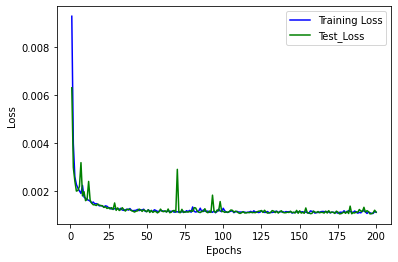

In [123]:
# Training_loss plot
n_epochs = np.arange(num_epochs)+1 
plt.plot(n_epochs, total_train_loss, 'b')
plt.plot(n_epochs, total_test_loss, 'g')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(["Training Loss", "Test_Loss"], loc ="upper right")
plt.savefig("Train_test_loss_200_epochs.png",dpi=300)
plt.show()

####Save and Load parameters trained red

In [107]:
# Save parameter trained red
PATH = './Autoencoder_max_200_epochs.pth'
torch.save(model.state_dict(), PATH)

In [124]:
# Loading the trained network
PATH = './Autoencoder_max_200_epochs.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

##Evaluate Model

### Test images

In [176]:
# Evaluate the model with the test images
output_test = [model(img.to(device)) for (img) in test_load]
output_test = [output_test[img].detach().cpu().numpy() for img in range(len(test_load))]
output_test = np.array((output_test))
output_test.shape

(669, 1, 1, 128, 128)

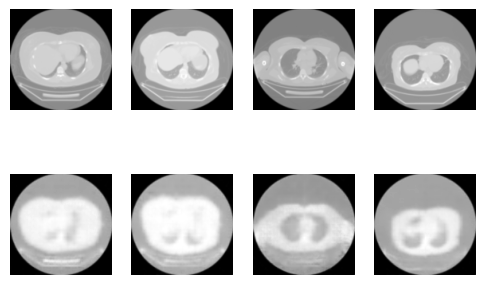

In [190]:
im_test = [20, 30, 50, 100] #index of test images
fig, ax = plt.subplots(2, 4, dpi=100) 
ax[0,0].imshow(test_data[im_test[0],0,:,:], cmap='gray')
ax[0,0].axis('off')
ax[1,0].imshow(output_test[im_test[0],0,0,:,:], cmap='gray')
ax[1,0].axis('off')
ax[0,1].imshow(test_data[im_test[1],0,:,:], cmap='gray')
ax[0,1].axis('off')
ax[1,1].imshow(output_test[im_test[1],0,0,:,:], cmap='gray')
ax[1,1].axis('off')
ax[0,2].imshow(test_data[im_test[2],0,:,:], cmap='gray')
ax[0,2].axis('off')
ax[1,2].imshow(output_test[im_test[2],0,0,:,:], cmap='gray')
ax[1,2].axis('off')
ax[0,3].imshow(test_data[im_test[3],0,:,:], cmap='gray')
ax[0,3].axis('off')
ax[1,3].imshow(output_test[im_test[3],0,0,:,:], cmap='gray')
ax[1,3].axis('off')
plt.show()
fig.savefig("Predict_test.png",dpi=300)


###Noise test images

####Noise Generator

In [129]:
def im_noisy(image, mean, sigma):
    row, col = image.shape
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    return np.clip(noisy,0,1)

def im_poisson(image, lam):
    row, col = image.shape
    poisson = np.random.poisson(lam,(row,col))
    poisson = poisson.reshape(row,col)
    noisy = image + poisson
    return np.clip(noisy, 0,1)

####Gaussian noise

In [199]:
def noise_data(mean, sigma):
  test_data_noise = [im_noisy(test_data[i,0,:,:], mean, sigma) for i in range(test_data.shape[0])]
  test_data_noise = np.array(test_data_noise)
  test_data_noise = test_data_noise[:,np.newaxis,:,:] 
  test_data_noise = test_data_noise.astype(np.float32)
  return test_data_noise

sigma_noise = [0.05, 0.1, 0.2, 0.5] #Different standard deviations of Gaussian noise
test_data_noise = [noise_data(0,sigma) for sigma in sigma_noise]

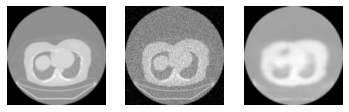

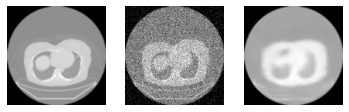

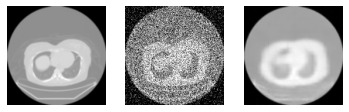

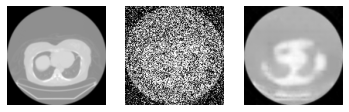

In [201]:
im_test = 100
for sigma in range(len(sigma_noise)):
  test_noise = torch.from_numpy(test_data_noise[sigma]) 
  test_load_noise = torch.utils.data.DataLoader(dataset=test_noise, batch_size=1, shuffle=False) 
  output_test_noise = [model(img.to(device)) for (img) in test_load_noise]
  im_noise = output_test_noise[im_test].detach().cpu().numpy()

  fig, ax = plt.subplots(1, 3)  
  ax[0].imshow(test_data[im_test,0,:,:], cmap='gray')
  ax[0].axis('off')
  ax[1].imshow(test_data_noise[sigma][im_test,0,:,:], cmap='gray')
  ax[1].axis('off')
  ax[2].imshow(im_noise[0,0,:,:], cmap='gray')
  ax[2].axis('off')
  plt.show()

####Poisson Noise

In [202]:
def poisson_noise(lam):
  test_data_poisson = [im_poisson(test_data[i,0,:,:], 0.05) for i in range(test_data.shape[0])]
  test_data_poisson = np.array(test_data_poisson)
  test_data_poisson = test_data_poisson[:,np.newaxis,:,:] 
  test_data_poisson = test_data_poisson.astype(np.float32)
  return test_data_poisson

lam_noise = [0.01, 0.1, 1, 10] #Diferent number of events 
test_data_poisson = [poisson_noise(lam) for lam in lam_noise]

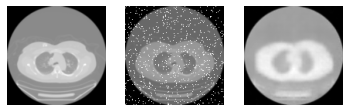

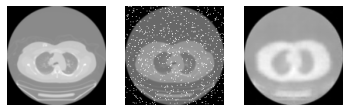

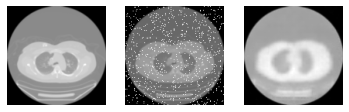

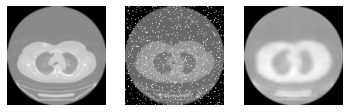

In [203]:
im_test = 250
for lam in range(len(lam_noise)):
  test_noise = torch.from_numpy(test_data_poisson[lam]) 
  test_load_noise = torch.utils.data.DataLoader(dataset=test_noise, batch_size=1, shuffle=False) 
  output_test_noise = [model(img.to(device)) for (img) in test_load_noise]
  im_noise = output_test_noise[im_test].detach().cpu().numpy()

  fig, ax = plt.subplots(1, 3)  
  ax[0].imshow(test_data[im_test,0,:,:], cmap='gray')
  ax[0].axis('off')
  ax[1].imshow(test_data_poisson[lam][im_test,0,:,:], cmap='gray')
  ax[1].axis('off')
  ax[2].imshow(im_noise[0,0,:,:], cmap='gray')
  ax[2].axis('off')
  plt.show()
fig.savefig("Predict_test_poisson.png",dpi=300)
